# Find probability of your dying as a Titanic Passenger

### The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

# Load the DATA

In [814]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score,roc_auc_score, confusion_matrix
import joblib
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

!pip install lazypredict --quiet
from lazypredict.Supervised import LazyRegressor, LazyClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV

!pip install xgboost --quiet
from xgboost import XGBClassifier

In [815]:
#reading the csv
data = pd.read_csv('./dataset/train.csv')

# Lowering the column names
data.columns = data.columns.str.lower()

# showing some samples
data.sample(10)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
754,755,1,2,"Herman, Mrs. Samuel (Jane Laver)",female,48.00,1,2,220845,65.00,NaN,S
830,831,1,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15.00,1,0,2659,14.45,NaN,C
63,64,0,3,"Skoog, Master. Harald",male,4.00,3,2,347088,27.90,NaN,S
504,505,1,1,"Maioni, Miss. Roberta",female,16.00,0,0,110152,86.50,B79,S
49,50,0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.00,1,0,349237,17.80,NaN,S
231,232,0,3,"Larsson, Mr. Bengt Edvin",male,29.00,0,0,347067,7.78,NaN,S
664,665,1,3,"Lindqvist, Mr. Eino William",male,20.00,1,0,STON/O 2. 3101285,7.92,NaN,S
475,476,0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.00,A14,S
418,419,0,2,"Matthews, Mr. William John",male,30.00,0,0,28228,13.00,NaN,S
293,294,0,3,"Haas, Miss. Aloisia",female,24.00,0,0,349236,8.85,NaN,S


In [816]:
data.shape

(891, 12)

In [817]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [818]:
data.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


In [819]:
# creating a copy of data for eda
df = data.copy()

## Preprocessing for EDA

In [820]:
# Dropping columns that is not required
df = df.drop(['passengerid', 'name', 'ticket'], axis = 1)

In [821]:
df.shape

(891, 9)

In [822]:
df.sample(10)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked
258,1,1,female,35.00,0,0,512.33,NaN,C
43,1,2,female,3.00,1,2,41.58,NaN,C
842,1,1,female,30.00,0,0,31.00,NaN,C
871,1,1,female,47.00,1,1,52.55,D35,S
731,0,3,male,11.00,0,0,18.79,NaN,C
604,1,1,male,35.00,0,0,26.55,NaN,C
454,0,3,male,NaN,0,0,8.05,NaN,S
726,1,2,female,30.00,3,0,21.00,NaN,S
32,1,3,female,NaN,0,0,7.75,NaN,Q
659,0,1,male,58.00,0,2,113.28,D48,C


In [823]:
### Finding nulls

In [824]:
df.isnull().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
cabin       687
embarked      2
dtype: int64

# EDA

## Univariate Analysis

> Note: Here we will be filling null with extreme value to distinguies and see its impact on output

#### Sex vs Survival

Text(0.5, 1.0, 'Sex and survival Counts')

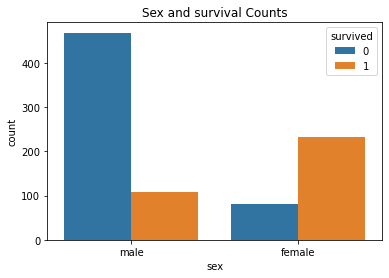

In [825]:
sns.countplot(x = df.sex, hue = df.survived)
plt.title('Sex and survival Counts')

0: not survived, 1: survived

In [826]:
# female survival rate
female_survival_rate = df[(df.sex =='female') & (df.survived == 1)].sex.count()/(df.sex.value_counts()['female'])

# female survival rate
male_survival_rate = df[(df.sex =='male') & (df.survived == 1)].sex.count()/(df.sex.value_counts()['male'])

print(f'Male Survival rate: {male_survival_rate} \nFemale Survival Rate: {female_survival_rate}')

Male Survival rate: 0.18890814558058924 
Female Survival Rate: 0.7420382165605095


So Probability of 

* Male passenger to be survived is : **18.89%**
* Female passenger to survive      : **74.20%**

Note: Females have nearly 4X survial rate than males

### Age vs Survival

There are 177 missing values and we will impute and see if missing values have correlation with output

In [827]:
df[df.age > 100]

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked


Since there are no one older than 100 , we will fill missing values with 100, just to check

In [828]:
df.age = df.age.fillna(101)

In [829]:
age_bins = [0,5,15,24,64,100,101]

age_categories = ['baby','kid', 'youth','adult','senior', 'immortal']

In [830]:
df['agerange'] = pd.cut(df['age'], age_bins, labels=age_categories)

In [831]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,agerange
0,0,3,male,22.00,1,0,7.25,NaN,S,youth
1,1,1,female,38.00,1,0,71.28,C85,C,adult
2,1,3,female,26.00,0,0,7.92,NaN,S,adult
3,1,1,female,35.00,1,0,53.10,C123,S,adult
4,0,3,male,35.00,0,0,8.05,NaN,S,adult


In [832]:
df.agerange.value_counts()

adult       426
youth       194
immortal    177
baby         44
kid          39
senior       11
Name: agerange, dtype: int64

<AxesSubplot:xlabel='agerange', ylabel='count'>

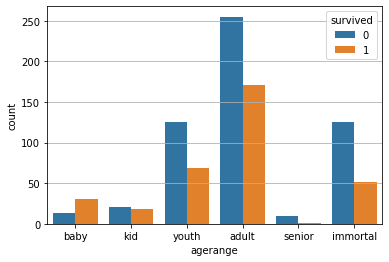

In [833]:
plt.grid(True)
sns.countplot(x = df.agerange, hue = df.survived )

**Note:** Babies and kids are more likely to survive

In [834]:
df[df.age == 101].survived.value_counts()

0    125
1     52
Name: survived, dtype: int64

### Pclass vs Survival

In [835]:
# nulls in plcass
df.pclass.isnull().sum()

0

<AxesSubplot:xlabel='pclass', ylabel='count'>

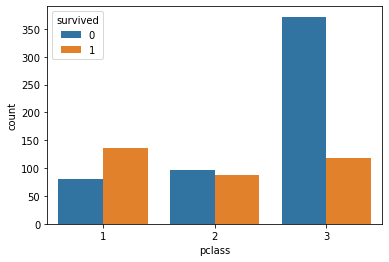

In [836]:
sns.countplot(x = df.pclass, hue = df.survived)

In [837]:
#class survival probability
class1_survival = (df[df.pclass == 1].survived.value_counts()[1])/ (df.pclass.value_counts()[1])

class2_survival = (df[df.pclass == 2].survived.value_counts()[1])/ (df.pclass.value_counts()[2])

class3_survival = (df[df.pclass == 3].survived.value_counts()[1])/ (df.pclass.value_counts()[3])

In [838]:
print(f'Pclass 1 survival probability : {class1_survival:.2}')
print(f'Pclass 2 survival probability : {class2_survival:.2}')
print(f'Pclass 3 survival probability : {class3_survival:.2}')

Pclass 1 survival probability : 0.63
Pclass 2 survival probability : 0.47
Pclass 3 survival probability : 0.24


**Note:** Passenegers from pclass 1 and 2 have more probability to survive

### sibsp vs Survival

Sibsp - Number of Siblings/Spouses Aboard

In [839]:
# null check
df.sibsp.isnull().sum()

0

<AxesSubplot:xlabel='count', ylabel='sibsp'>

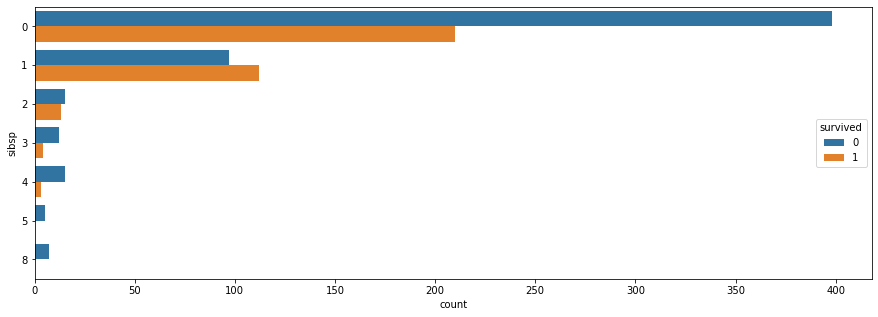

In [840]:
plt.figure(figsize=(15,5))
sns.countplot(y = df.sibsp, hue = df.survived)

**Note:** family member upto 2 people have good survial prob. than single people also big families do not survive

**Pro tip**: bring a date next time you get to board titanic

### parch vs Survival

Parch - Number of Parents/Children Aboard.

In [841]:
df.parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: parch, dtype: int64

<AxesSubplot:xlabel='count', ylabel='parch'>

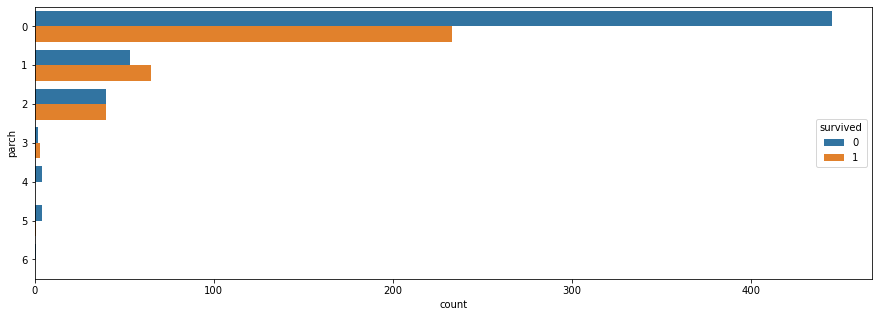

In [842]:
plt.figure(figsize=(15,5))
sns.countplot(y = df.parch, hue = df.survived)

**Note:** family member upto 2 people have good survial prob. than single people also big families do not survive

Distinction between siblings and number of parent/children are vague. They could have just gone with number of family members.

Also distribution is almost the same

### Fare vs Survival

In [843]:
df.fare.isnull().sum() # null check

0

Text(0.5, 1.0, "surviver's fare")

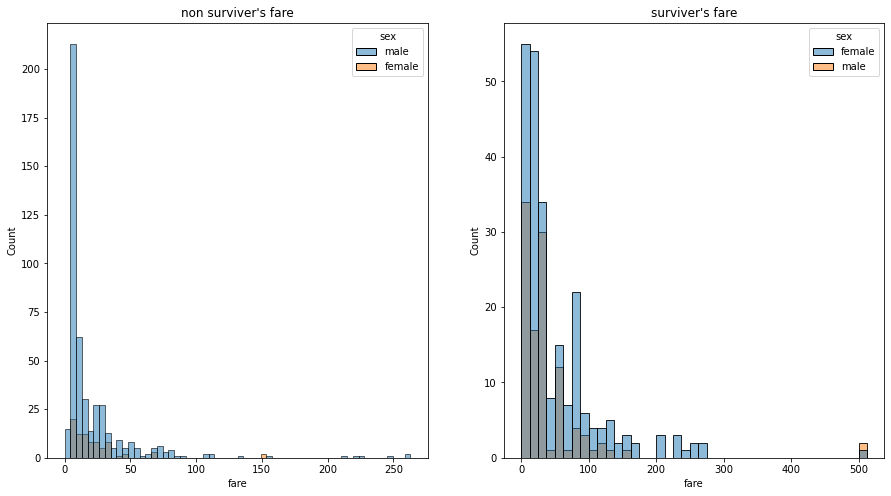

In [844]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.histplot(x = df[df.survived == 0].fare, hue = df[df.survived == 0].sex )
plt.title("non surviver's fare")

plt.subplot(1,2,2)
sns.histplot(x = df[df.survived == 1].fare, hue = df[df.survived == 1].sex, alpha = .5)
plt.title("surviver's fare")


(0.0, 100.0)

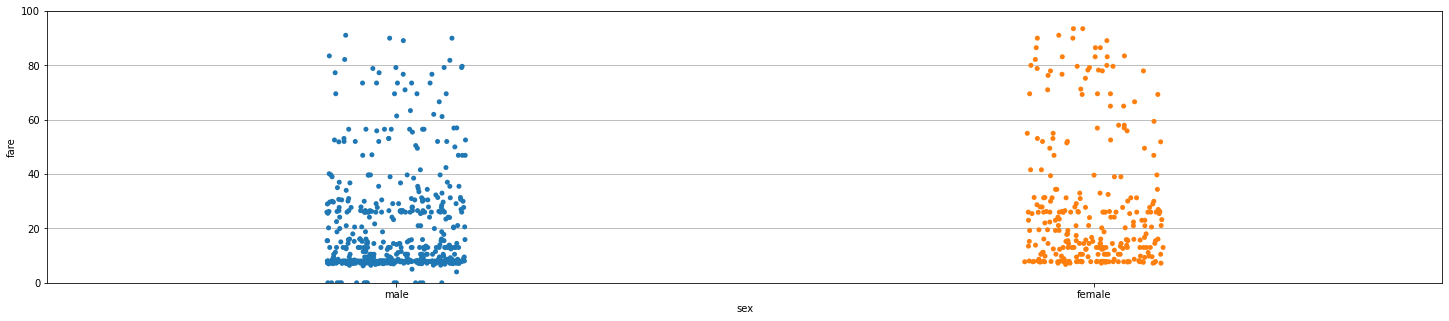

In [845]:
plt.figure(figsize = (25,5))
plt.grid(True)
sns.stripplot(y = df['fare'], x = df['sex'])
plt.ylim([0,100])

### Cabin vs Survival

In [846]:
# check nulls
df.cabin.isnull().sum()

687

Since there are alot of null we will fill it with value xxx and see correlation of nulls to output

In [847]:
df['cabin'] = df.cabin.fillna('xxx')


In [848]:
df[df.survived == 1].cabin.value_counts().sort_values(ascending = False)

xxx        206
B96 B98      4
E101         3
F33          3
D20          2
          ... 
A26          1
D11          1
B69          1
C47          1
C148         1
Name: cabin, Length: 102, dtype: int64

In [849]:
df[df.survived == 0].cabin.value_counts().sort_values(ascending = False)

xxx            481
C22 C26          2
C124             2
D26              2
G6               2
              ... 
D6               1
B82 B84          1
A36              1
A24              1
B51 B53 B55      1
Name: cabin, Length: 63, dtype: int64

out of 687 missing values of cabin 206 survived while other were jacked(died).

### Embarked vs Survival

In [850]:
df.embarked.isnull().sum()

2

In [851]:
# filling missing with median
df.embarked.value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [852]:
df.embarked.fillna('S', inplace=True)

<AxesSubplot:xlabel='embarked', ylabel='count'>

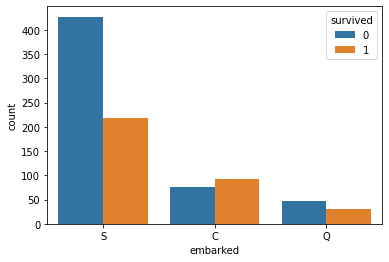

In [853]:
sns.countplot(x= df.embarked, hue = df.survived)

**Note**: Embarked C has highest Chance of survival followed by Q then S.

## Bivariate analysis

In [854]:
df.isnull().sum()

survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
agerange    0
dtype: int64

<AxesSubplot:>

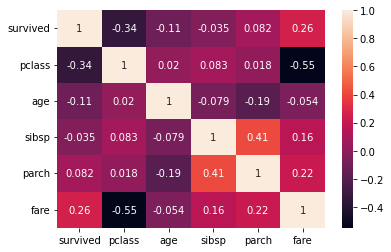

In [855]:
sns.heatmap(df.corr(), annot = True, fmt = '.2g')

As we have seen before that sibsp and parch did not have a big difference and Also they have high correlation, 
so, We will create a new column as family member and sum both parch and sibsp columns

In [856]:
df['family'] = df.parch + df.sibsp

In [857]:
# dropping parch and sibsp
df.drop(['parch','sibsp'], axis = 1, inplace = True)

<AxesSubplot:>

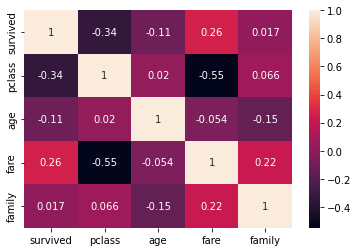

In [858]:
sns.heatmap(df.corr(), annot = True, fmt = '.2g')

We will test this data on model to see it has any significance

In [859]:
#separating dfs
sur_df = df[df.survived == 1]
nor_sur_df = df[df.survived == 0 ]

In [860]:
def pairplot(df, figsize = (20,20), hue:str = None):
    num_cols = df.select_dtypes('number').columns
    print(num_cols)

    total_cols = len(num_cols)
    plot_num = 1

    plt.figure(figsize=(20,20))
    for col in num_cols:
        for col2 in num_cols:
            plt.subplot(total_cols, total_cols, plot_num)
            plot_num += 1

            if col == col2:
                sns.histplot(x = df[col], hue = df[hue])

            else:
                sns.scatterplot(x = df[col], y = df[col2], hue = df[hue])

Index(['survived', 'pclass', 'age', 'fare', 'family'], dtype='object')


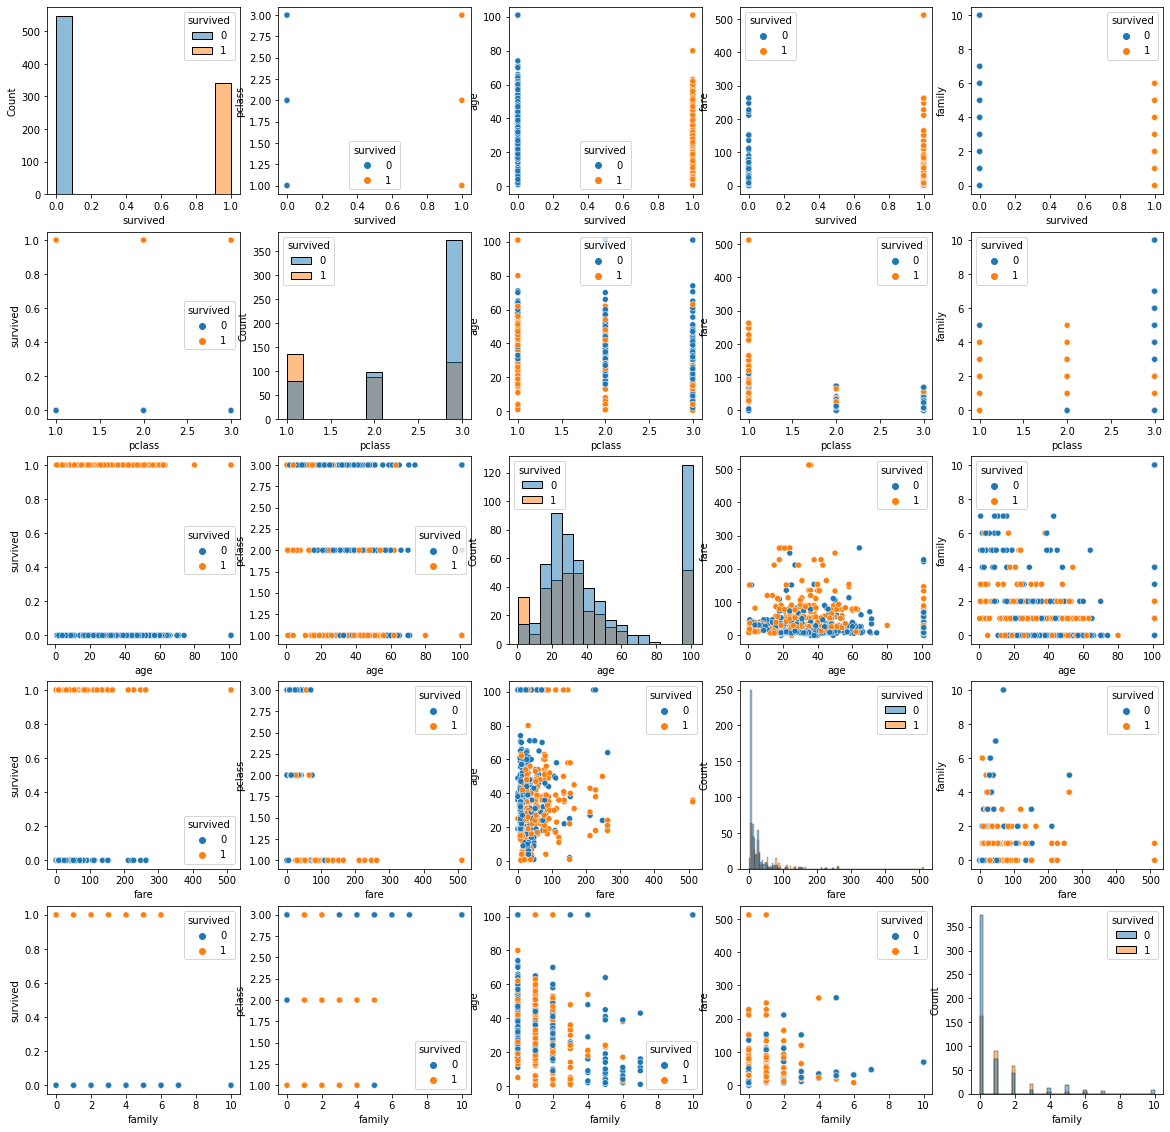

In [861]:
pairplot(df, hue = 'survived')

In [862]:
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


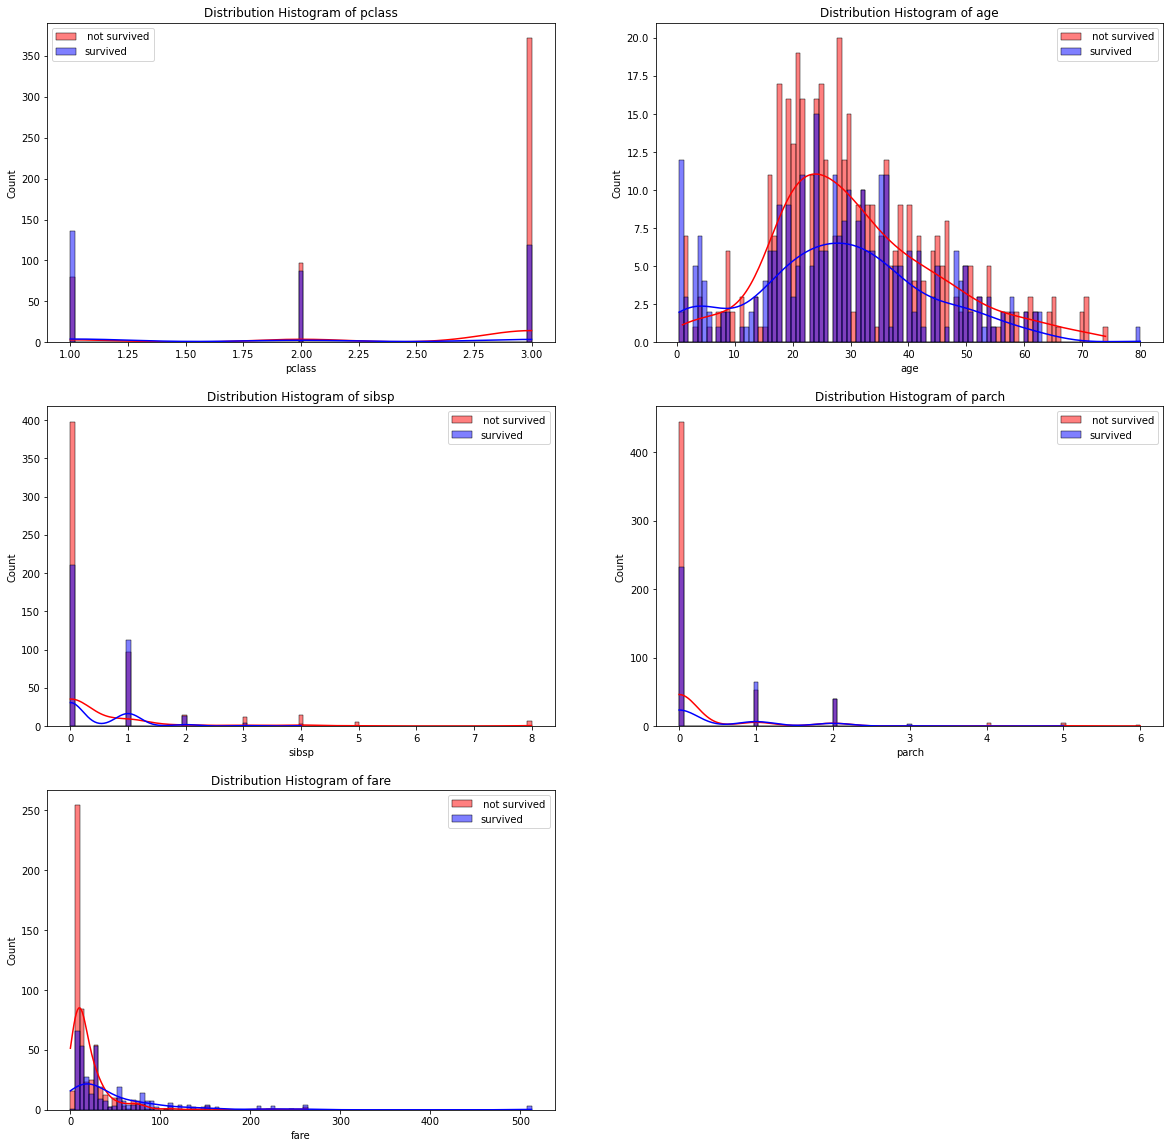

In [863]:

#creating temp 
_survived = data[(data.survived==1)]
_not_survived = data[data.survived==0]

plt.figure(figsize = (20,20))
cols = ['pclass', 'age', 'sibsp', 'parch', 'fare']
for i,col in enumerate(cols):
    plt.subplot(3,2,i+1)
    # d_plot(cols[i])
    # plt.title(cols[i])
    data1 = _survived[col]
    data2 = _not_survived[col]
    # plt.figure(figsize=(15,5))
    bins = np.linspace(data[col].min(), data[col].max(), 100)

    sns.histplot(data2, bins=bins, alpha=0.5, color='red', kde=True,label=' not survived')
    sns.histplot(data1, bins=bins, alpha=0.5, color = 'blue', kde=True,label='survived')
    
    plt.gca().set(title=f'Distribution Histogram of {col}', ylabel='Count')
    plt.legend()

# Preprocessing

Things to do
1. Fill nan
2. Encode categories
3. Normalize


In [864]:
# we will be using original data from here
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [865]:
# dropping columns
data.drop(['passengerid','name','ticket'], axis = 1, inplace = True)

In [866]:
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked
0,0,3,male,22.00,1,0,7.25,NaN,S
1,1,1,female,38.00,1,0,71.28,C85,C
2,1,3,female,26.00,0,0,7.92,NaN,S
3,1,1,female,35.00,1,0,53.10,C123,S
4,0,3,male,35.00,0,0,8.05,NaN,S


## a. Encoding categories

In [867]:
#encoding sex
sex_ohe = OneHotEncoder(sparse=False, drop = 'first')
sex_enc = sex_ohe.fit_transform(data['sex'].to_numpy().reshape(-1,1))
sex_enc = pd.DataFrame(sex_enc, columns=[sex_ohe.categories_[0][-1]])

# print(sex_enc)

#encoding embark
embark_ohe = OneHotEncoder(sparse = False)
embark_enc = embark_ohe.fit_transform(data['embarked'].to_numpy().reshape(-1,1))
embark_enc = pd.DataFrame(embark_enc, columns=[*embark_ohe.categories_[0]])

## encoding cabin
# cabin_enc = pd.get_dummies(data['cabin'], dummy_na=True)

#dropping categories
data.drop(['embarked','sex','cabin'], axis  = 1, inplace=True)

# joining encoded embark
data = pd.concat([data, sex_enc, embark_enc], axis = 1)

# data.head()

In [868]:
data.head()

,survived,pclass,age,sibsp,parch,fare,male,C,Q,S,NaN
0,0,3,22.00,1,0,7.25,1.00,0.00,0.00,1.00,0.00
1,1,1,38.00,1,0,71.28,0.00,1.00,0.00,0.00,0.00
2,1,3,26.00,0,0,7.92,0.00,0.00,0.00,1.00,0.00
3,1,1,35.00,1,0,53.10,0.00,0.00,0.00,1.00,0.00
4,0,3,35.00,0,0,8.05,1.00,0.00,0.00,1.00,0.00


In [869]:
[sex_ohe.categories_[0][-1]]

['male']

In [870]:
data.isnull().sum()

survived      0
pclass        0
age         177
sibsp         0
parch         0
fare          0
male          0
C             0
Q             0
S             0
NaN           0
dtype: int64

## b. Filling nan(s)

In [871]:
# imputing age with knn imputer
imputer = KNNImputer(n_neighbors=5,add_indicator=True)

ff = imputer.fit_transform(X = data)

In [872]:
data['age'] = ff[:,2].astype('int16')

In [873]:
data.age.isnull().sum()

0

In [915]:
data.head()

,survived,pclass,age,sibsp,parch,fare,male,C,Q,S,NaN
0,0,3,22,1,0,7.25,1.00,0.00,0.00,1.00,0.00
1,1,1,38,1,0,71.28,0.00,1.00,0.00,0.00,0.00
2,1,3,26,0,0,7.92,0.00,0.00,0.00,1.00,0.00
3,1,1,35,1,0,53.10,0.00,0.00,0.00,1.00,0.00
4,0,3,35,0,0,8.05,1.00,0.00,0.00,1.00,0.00


In [875]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   age       891 non-null    int16  
 3   sibsp     891 non-null    int64  
 4   parch     891 non-null    int64  
 5   fare      891 non-null    float64
 6   male      891 non-null    float64
 7   C         891 non-null    float64
 8   Q         891 non-null    float64
 9   S         891 non-null    float64
 10  nan       891 non-null    float64
dtypes: float64(6), int16(1), int64(4)
memory usage: 71.5 KB


In [876]:
# feature and responces
X = data.drop('survived', axis =1)
y = data.survived

## c. Class Imabalance

In [877]:
data.survived.value_counts()

0    549
1    342
Name: survived, dtype: int64

In [878]:
# instanciating SMOTE
over_sampler = SMOTE(n_jobs=-1)
# resampling
x_balanced, y_balanced = over_sampler.fit_resample(X,y)

In [879]:
x_balanced.head()

,pclass,age,sibsp,parch,fare,male,C,Q,S,NaN
0,3,22,1,0,7.25,1.00,0.00,0.00,1.00,0.00
1,1,38,1,0,71.28,0.00,1.00,0.00,0.00,0.00
2,3,26,0,0,7.92,0.00,0.00,0.00,1.00,0.00
3,1,35,1,0,53.10,0.00,0.00,0.00,1.00,0.00
4,3,35,0,0,8.05,1.00,0.00,0.00,1.00,0.00


In [880]:
print('Class count before oversampling: ',np.bincount(y))
print('Class count after oversampling: ',np.bincount(y_balanced))

Class count before oversampling:  [549 342]
Class count after oversampling:  [549 549]


In [881]:
## Splitting data dataset
xtrain_bala, xtest_bala, ytrain_bala, ytest_bala = train_test_split(x_balanced, 
                                                                    y_balanced ,
                                                                    test_size=.1, 
                                                                    random_state=2, 
                                                                    stratify= y_balanced)

In [882]:
print('xtrain: ', xtrain_bala.shape, ' ytrain: ', ytrain_bala.shape)
print('xtest:  ', xtest_bala.shape, ' ytest:  ', ytest_bala.shape)

xtrain:  (988, 10)  ytrain:  (988,)
xtest:   (110, 10)  ytest:   (110,)


## d. Scaling

In [883]:
## Splitting data dataset
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, y , test_size=.1, random_state=2, stratify= y)

In [884]:
print('xtrain: ', xtrain.shape, ' ytrain: ', ytrain.shape)
print('xtest:  ', xtest.shape, ' ytest:  ', ytest.shape)

xtrain:  (801, 10)  ytrain:  (801,)
xtest:   (90, 10)  ytest:   (90,)


In [885]:
#scaling non  balanced split
scaler = MinMaxScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

#scaling balanced splits
scaler_balanced = MinMaxScaler()
xtrain_bala_scaled = scaler_balanced.fit_transform(xtrain_bala)
xtest_bala_scaled = scaler_balanced.transform(xtest_bala)


# Helpler Function

In [886]:
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    Args:
    -----
    y_true = true labels in the form of a 1D array
    y_pred = predicted labels in the form of a 1D array
    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {
				"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
    return model_results

# Models Training (Lazy)

In [887]:
# LazyClassifier Instance and fiting data
cls= LazyClassifier(ignore_warnings=False, custom_metric=None)
models, predictions = cls.fit(xtrain_scaled, xtest_scaled, ytrain, ytest)

 31%|██████████████████                                        | 9/29 [00:00<00:00, 24.22it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|█████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 30.50it/s]

StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


In [888]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.88,0.87,0.87,0.88,0.05
Perceptron,0.87,0.86,0.86,0.87,0.01
RandomForestClassifier,0.86,0.86,0.86,0.86,0.14
LGBMClassifier,0.86,0.85,0.85,0.86,0.06
KNeighborsClassifier,0.86,0.85,0.85,0.86,0.01
ExtraTreesClassifier,0.84,0.85,0.85,0.85,0.11
LogisticRegression,0.86,0.85,0.85,0.86,0.02
SVC,0.87,0.84,0.84,0.86,0.03
SGDClassifier,0.86,0.84,0.84,0.85,0.01


In [889]:
# fitting on balanced data
cls_bala= LazyClassifier(ignore_warnings=False, custom_metric=None)
models_bala, predictions_bala = cls.fit(xtrain_bala_scaled, xtest_bala_scaled, ytrain_bala, ytest_bala)

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


 31%|██████████████████                                        | 9/29 [00:00<00:00, 21.84it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|█████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 26.68it/s]

StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


In [890]:
models_bala

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.85,0.85,0.85,0.85,0.06
LGBMClassifier,0.85,0.85,0.85,0.85,0.06
KNeighborsClassifier,0.83,0.83,0.83,0.83,0.01
SVC,0.83,0.83,0.83,0.83,0.03
RandomForestClassifier,0.83,0.83,0.83,0.83,0.16
LogisticRegression,0.83,0.83,0.83,0.83,0.01
AdaBoostClassifier,0.83,0.83,0.83,0.83,0.11
LinearSVC,0.82,0.82,0.82,0.82,0.07
CalibratedClassifierCV,0.82,0.82,0.82,0.82,0.16


# Models2

In [891]:
clfs = {'logistic regression': LogisticRegression(),
        'SVM': SVC(probability=True),
        'Knn': KNeighborsClassifier(n_neighbors=5),
        'D Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators = 20),
        'Xtra Random Forest': ExtraTreesClassifier(n_estimators = 20),
        'naive bayes': BernoulliNB()}

In [892]:
#function to train all model at once
def allmodels(x_train=None, y_train=None, x_test=None, y_test=None):
    sscores = []
    for name, model in clfs.items():
        model.fit(x_train, y_train)
        ypred = model.predict(x_test)
        result = {'model' : name}
        result.update(calculate_results(y_test, ypred))
        sscores.append(result)
    return sscores

## XGB Classifier

In [893]:
def xgb(x_train=None, y_train=None, x_test=None, y_test=None):
    xgb = XGBClassifier()
    xgb.fit(x_train, y_train)
    ypred = xgb.predict(x_test)

    # calculate  result
    xgb_result = calculate_results(y_test, ypred)
    xgb_result['model'] = 'xgb'

    return xgb_result

In [894]:
# get the scores

In [895]:
#training all models
score = allmodels(xtrain_scaled, ytrain, xtest_scaled, ytest)
print(xtrain_bala_scaled.shape, ytrain_bala.shape, xtest_bala_scaled.shape, ytest_bala.shape)
score2 = allmodels(xtrain_bala_scaled, ytrain_bala, xtest_bala_scaled, ytest_bala)

#training xgb model
xgb_result = xgb(xtrain_scaled, ytrain, xtest_scaled, ytest)
xgb_result_bala = xgb(xtrain_bala_scaled, ytrain_bala, xtest_bala_scaled, ytest_bala)

# add score to dataframe
score.append(xgb_result)
score2.append(xgb_result_bala)

(988, 10) (988,) (110, 10) (110,)


In [896]:
# scoresheet
scoresheet = pd.DataFrame(score) # unbalanced data
scoresheet2 = pd.DataFrame(score2) # balanced data
scoresheet

,model,accuracy,precision,recall,f1
0,logistic regression,85.56,0.85,0.86,0.85
1,SVM,82.22,0.83,0.82,0.81
2,Knn,86.67,0.87,0.87,0.87
3,D Tree,80.00,0.80,0.80,0.80
4,Random Forest,85.56,0.86,0.86,0.86
5,Xtra Random Forest,82.22,0.83,0.82,0.82
6,naive bayes,77.78,0.78,0.78,0.77
7,xgb,87.78,0.88,0.88,0.88


In [897]:
scoresheet2

,model,accuracy,precision,recall,f1
0,logistic regression,80.91,0.81,0.81,0.81
1,SVM,77.27,0.80,0.77,0.77
2,Knn,82.73,0.84,0.83,0.83
3,D Tree,71.82,0.73,0.72,0.72
4,Random Forest,81.82,0.82,0.82,0.82
5,Xtra Random Forest,84.55,0.85,0.85,0.85
6,naive bayes,80.91,0.81,0.81,0.81
7,xgb,85.45,0.86,0.85,0.85


# Fine Tuning `XGBClassifier`

In [898]:
boost_params = {
    'learning_rate': [0.01, 0.005, 0.1 ,1],
    'n_estimators': [100, 200, 150],
    'max_depth':range(3,10,2),
    'min_child_weight':[6,8,10,12],
    'gamma':[i/5.0 for i in range(0,10)],
#     'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)],
    'reg_alpha':[1e-5,1e-3, 1e-2, 0.1, 1]

}

In [899]:
xgb = XGBClassifier(booster = 'gbtree', n_jobs=-1)

In [900]:
#balancing the complete dataset before fitting
big_scaler = MinMaxScaler()
x_balanced_scaled= big_scaler.fit_transform(x_balanced)


In [901]:
# fuction that performs cv
def random_search_cv(estimator, params, n_iters, cv = 5, return_train_score = True, **kwargs):
    'returns randomized search model, save it in a variable'
    random_cv = RandomizedSearchCV( estimator = estimator, 
                                          param_distributions = params, 
                                          n_iter= n_iters, 
                                           cv=cv,
                                          return_train_score = return_train_score,verbose = 1, **kwargs)
    random_cv.fit(x_balanced_scaled, y_balanced)
    print( f'''best score: {random_cv.best_score_}
    best estimator: {random_cv.best_estimator_}
    best params: {random_cv.best_params_}
    best index: {random_cv.best_index_}''')
    return random_cv

In [902]:
rscv = random_search_cv(xgb, boost_params, n_iters=100)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best score: 0.8616728933167289
    best estimator: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=6,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.1, reg_lambda=1, ...)
    best params: {'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.8}
    best index: 66


In [903]:
# getting the best params
xgb_param = rscv.best_params_
xgb_param

{'reg_alpha': 0.1,
 'n_estimators': 200,
 'min_child_weight': 6,
 'max_depth': 9,
 'learning_rate': 0.1,
 'gamma': 0.4,
 'colsample_bytree': 0.8}

In [904]:
xgb_tuned = XGBClassifier( n_estimators=xgb_param['n_estimators'],
#                                     subsample = xgb_param['subsample'],
                                    gamma = xgb_param['gamma'],
                                    learning_rate = xgb_param['learning_rate'],
                                    max_depth= xgb_param['max_depth'],
                          reg_alpha = xgb_param['reg_alpha'],
                          min_child_weight = xgb_param['min_child_weight'],
                          colsample_bytree = xgb_param['colsample_bytree'])

In [905]:
# fitting on splitted data to see performance
xgb_tuned.fit(xtrain_bala_scaled, ytrain_bala)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=6,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.1, reg_lambda=1, ...)

In [906]:
ypred = xgb_tuned.predict(xtest_bala_scaled)
calculate_results(y_true=ytest_bala, y_pred = ypred)

{'accuracy': 85.45454545454545,
 'precision': 0.8666666666666668,
 'recall': 0.8545454545454545,
 'f1': 0.8533333333333333}

In [907]:
# fittting on Whole data
xgb_tuned.fit(x_balanced_scaled, y_balanced)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=6,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.1, reg_lambda=1, ...)

# Testing the data

In [908]:
def preprocessing_data(data):
    
    data.columns = data.columns.str.lower()
    data.drop(['name', 'ticket','cabin', 'passengerid'], axis = 1, inplace = True)
    
    #encoding sex
    sex_enc = sex_ohe.transform(data['sex'].to_numpy().reshape(-1,1))
    sex_enc = pd.DataFrame(sex_enc, columns=[sex_ohe.categories_[0][-1]])

    #encoding embark
    embark_enc = embark_ohe.transform(data['embarked'].to_numpy().reshape(-1,1))
    embark_enc = pd.DataFrame(embark_enc, columns=[*embark_ohe.categories_[0]])

    # dropping categories
    data.drop(['embarked','sex'], axis  = 1, inplace=True)

    # joining encoded embark
    data = pd.concat([data, sex_enc, embark_enc], axis = 1)

    # scaler
    data = big_scaler.transform(data)

    return data


In [924]:
# loading the test data
test_data = pd.read_csv('./dataset/test.csv')
print(test_data.shape)
test_data.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S


In [925]:
# Preprocessing and predicting the test data
testdata =  preprocessing_data(test_data)  
result = xgb_tuned.predict(testdata)

In [926]:
result

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,

In [927]:
#read the true valus of test_Data
ytest_pred = pd.read_csv('./dataset/gender_submission.csv')
ytest_pred.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [929]:
ytest = ytest_pred.Survived

In [930]:
calculate_results(y_pred=result, y_true = ytest)

{'accuracy': 73.92344497607655,
 'precision': 0.7745203945492427,
 'recall': 0.7392344497607656,
 'f1': 0.7441758734132728}

# Saving the MODEL

In [911]:
# save the model
if not os.path.exists('model'):
    os.makedirs('model')
# saving the Model
joblib.dump(xgb_tuned,'./model/XGBClassifier.joblib')

['./model/XGBClassifier.joblib']

In [912]:
# saving all the assets
if not os.path.exists('saved'):
    os.makedirs('saved')
    
# saving encoders
joblib.dump(sex_ohe, './saved/sex_ohe.joblib') # sex encoder
joblib.dump(embark_ohe, './saved/embark_ohe.joblib') # embark encoder

# saving scaler
joblib.dump(big_scaler, './saved/big_scaler.joblib') # scaler

['./saved/big_scaler.joblib']

In [913]:
os.listdir('saved')

['big_scaler.joblib', 'sex_ohe.joblib', 'embark_ohe.joblib']